## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [13]:
#!pip install swifter
#!pip install worldcloud
#!pip install -U textblob
#!python -m textblob.download_corpora
#!pip install typing-extensions
#!pip install -U pip setuptools wheel -- to check
#!pip install -U spacy
#!python -m spacy download en_core_web_sm
#!pip install sklearn-crfsuite
#!pip install plotly
#!pip install cufflinks


In [126]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import swifter
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import itertools
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [127]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json")# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [128]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [129]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [130]:
#Assign new column names
df.rename(columns = lambda x:x.replace('_source.',''),inplace=True)
df.rename(columns = lambda x:x.strip('_'),inplace=True)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [131]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = np.where(df['complaint_what_happened'] == '',np.nan, df['complaint_what_happened'])
df['complaint_what_happened']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [132]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

In [133]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [134]:
# Write your function here to clean the text and remove all the unnecessary elements.

def cleanText(sentence):
    sentence = sentence.lower()
    sentence = re.sub("\[.*\]","",sentence)
    sentence = re.sub('[^\w\s]',' ',sentence)
    sentence = re.sub("\S*\d\S*", "",sentence)
    return sentence

df["complaint_what_happened"] = df["complaint_what_happened"].swifter.apply(cleanText)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [135]:
df.reset_index(drop = True, inplace=True)
df.loc[263,'complaint_what_happened']

'they keep charging overdraft fees on top of more fees the first charge was an bank error twice in one week is a bit much they barely give u a day to pay it back   e g  letting a check clear of other money services   they post charges when they want to catch you in fees i want to pay the bank the      i owe them they charge fees on top of fees its a cat and mouse game with a finical institute'

In [136]:
#Write your function to Lemmatize the texts
def lem_text(sentence):
    lem = []
    doc = nlp(sentence)
    for word in doc:
        lem.append(word.lemma_)
    return " ".join(lem)

# function to extract POS Tags

def get_postags(sentence):
    sentence = TextBlob(sentence)
    return ' '.join([word for (word,tag) in sentence.tags if tag == "NN" or tag == "NNS"])

df['complaints_lemma'] = df['complaint_what_happened'].swifter.apply(lem_text)
df['complaint_POS_removed'] = df['complaints_lemma'].swifter.apply(get_postags)


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [137]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_what_happened','complaints_lemma','complaint_POS_removed']].copy()
df_clean

,complaint_what_happened,complaints_lemma,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,card agent upgrade date agent information orde...
2,chase card was reported on xx xx however fr...,chase card be report on xx xx however fra...,card application identity consent service cred...
3,on xx xx while trying to book a xxxx xxxx ...,on xx xx while try to book a xxxx xxxx ...,try book xxxx ticket offer ticket card informa...
4,my grand son give me check for i deposit ...,my grand son give I check for I deposit ...,son chase account fund bank account pay money ...
...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
21068,on wednesday xx xx xxxx i called chas my xxx...,on wednesday xx xx xxxx I call chas my xxx...,visa credit card provider claim purchase prote...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
21070,i have had flawless credit for yrs i ve had ...,I have have flawless credit for yrs I ve h...,credit yrs credit card chase freedom xxxx prob...


In [138]:
df_clean

,complaint_what_happened,complaints_lemma,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,card agent upgrade date agent information orde...
2,chase card was reported on xx xx however fr...,chase card be report on xx xx however fra...,card application identity consent service cred...
3,on xx xx while trying to book a xxxx xxxx ...,on xx xx while try to book a xxxx xxxx ...,try book xxxx ticket offer ticket card informa...
4,my grand son give me check for i deposit ...,my grand son give I check for I deposit ...,son chase account fund bank account pay money ...
...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
21068,on wednesday xx xx xxxx i called chas my xxx...,on wednesday xx xx xxxx I call chas my xxx...,visa credit card provider claim purchase prote...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
21070,i have had flawless credit for yrs i ve had ...,I have have flawless credit for yrs I ve h...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




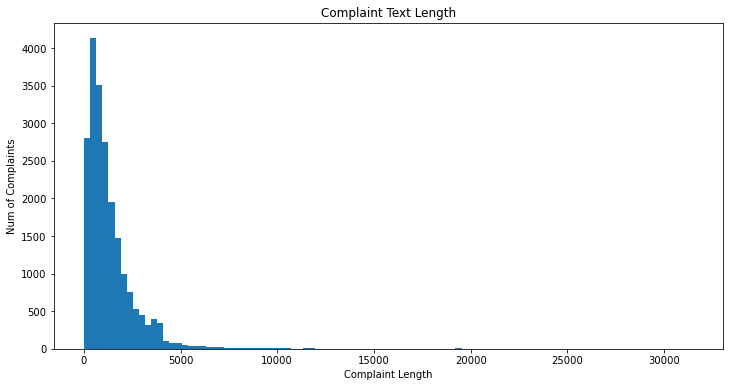

In [139]:
# Write your code here to visualise the data according to the 'Complaint' character length

df_clean['complaint_len'] = df_clean['complaint_what_happened'].astype(str).apply(len)

plt.figure(figsize=(12,6))
df_clean['complaint_len'].plot.hist(bins=100,title="Complaint Text Length")
plt.xlabel('Complaint Length')
plt.ylabel('Num of Complaints')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

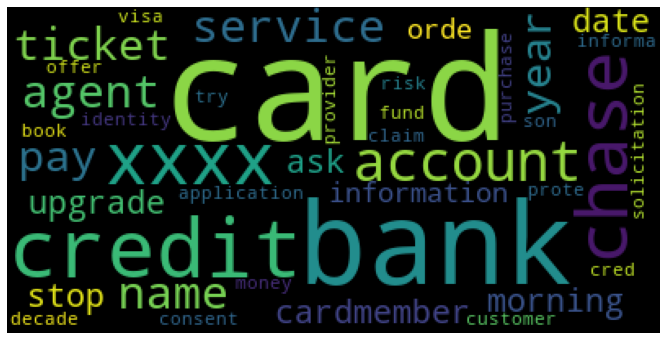

In [140]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud
stop_words = set(stopwords.words('english'))

wordcloud = WordCloud(stopwords=stop_words,max_words=40).generate(str(df_clean['complaint_POS_removed']))

plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();


In [141]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

,complaint_what_happened,complaints_lemma,complaint_POS_removed,complaint_len,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,482,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,card agent upgrade date agent information orde...,351,card agent upgrade date agent information orde...
2,chase card was reported on xx xx however fr...,chase card be report on xx xx however fra...,card application identity consent service cred...,220,card application identity consent service cred...
3,on xx xx while trying to book a xxxx xxxx ...,on xx xx while try to book a xxxx xxxx ...,try book xxxx ticket offer ticket card informa...,1470,try book xxxx ticket offer ticket card informa...
4,my grand son give me check for i deposit ...,my grand son give I check for I deposit ...,son chase account fund bank account pay money ...,466,son chase account fund bank account pay money ...
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,668,card customer decade solicitation credit card ...
21068,on wednesday xx xx xxxx i called chas my xxx...,on wednesday xx xx xxxx I call chas my xxx...,visa credit card provider claim purchase prote...,2113,visa credit card provider claim purchase prote...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,2317,pay risk provide consumer bank app chase year ...
21070,i have had flawless credit for yrs i ve had ...,I have have flawless credit for yrs I ve h...,credit yrs credit card chase freedom xxxx prob...,2129,credit yrs credit card chase freedom xxxx prob...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

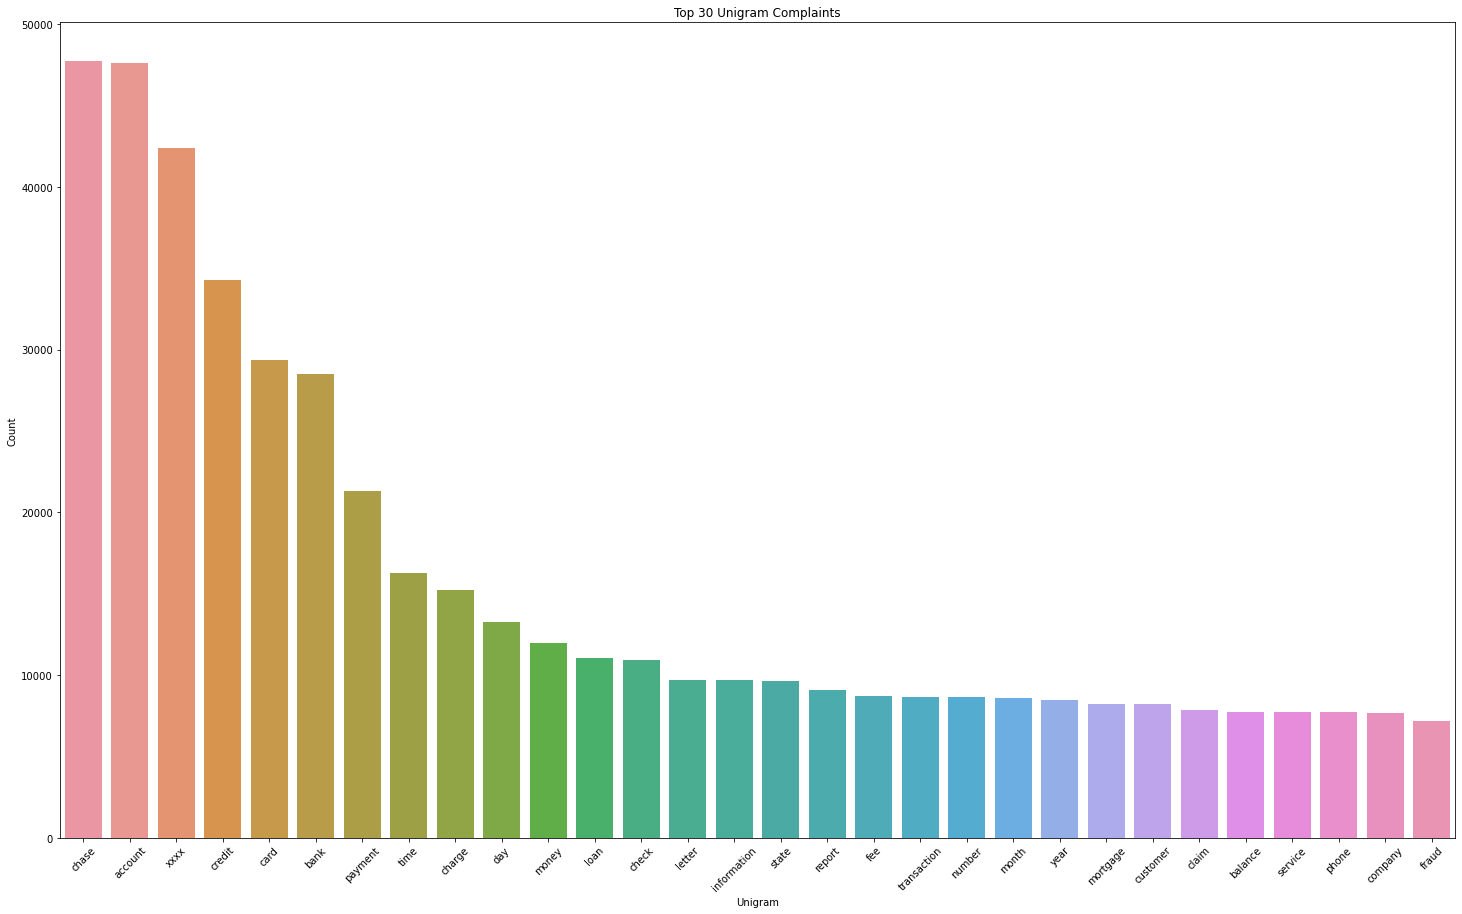

In [142]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top_ngram(corpus, n_gram_range, n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x:x[1],reverse=True)
    return words_freq[:n]

common_words = get_top_ngram(df_clean['Complaint_clean'],1,30)
df1 = pd.DataFrame(common_words, columns = ['Unigram','Count'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df1['Unigram'], y=df1['Count'])
plt.title('Top 30 Unigram Complaints')
plt.show()


In [143]:
#Print the top 10 words in the unigram frequency
df1.head(10)

,Unigram,Count
0,chase,47711
1,account,47630
2,xxxx,42360
3,credit,34277
4,card,29376
5,bank,28507
6,payment,21335
7,time,16286
8,charge,15201
9,day,13250


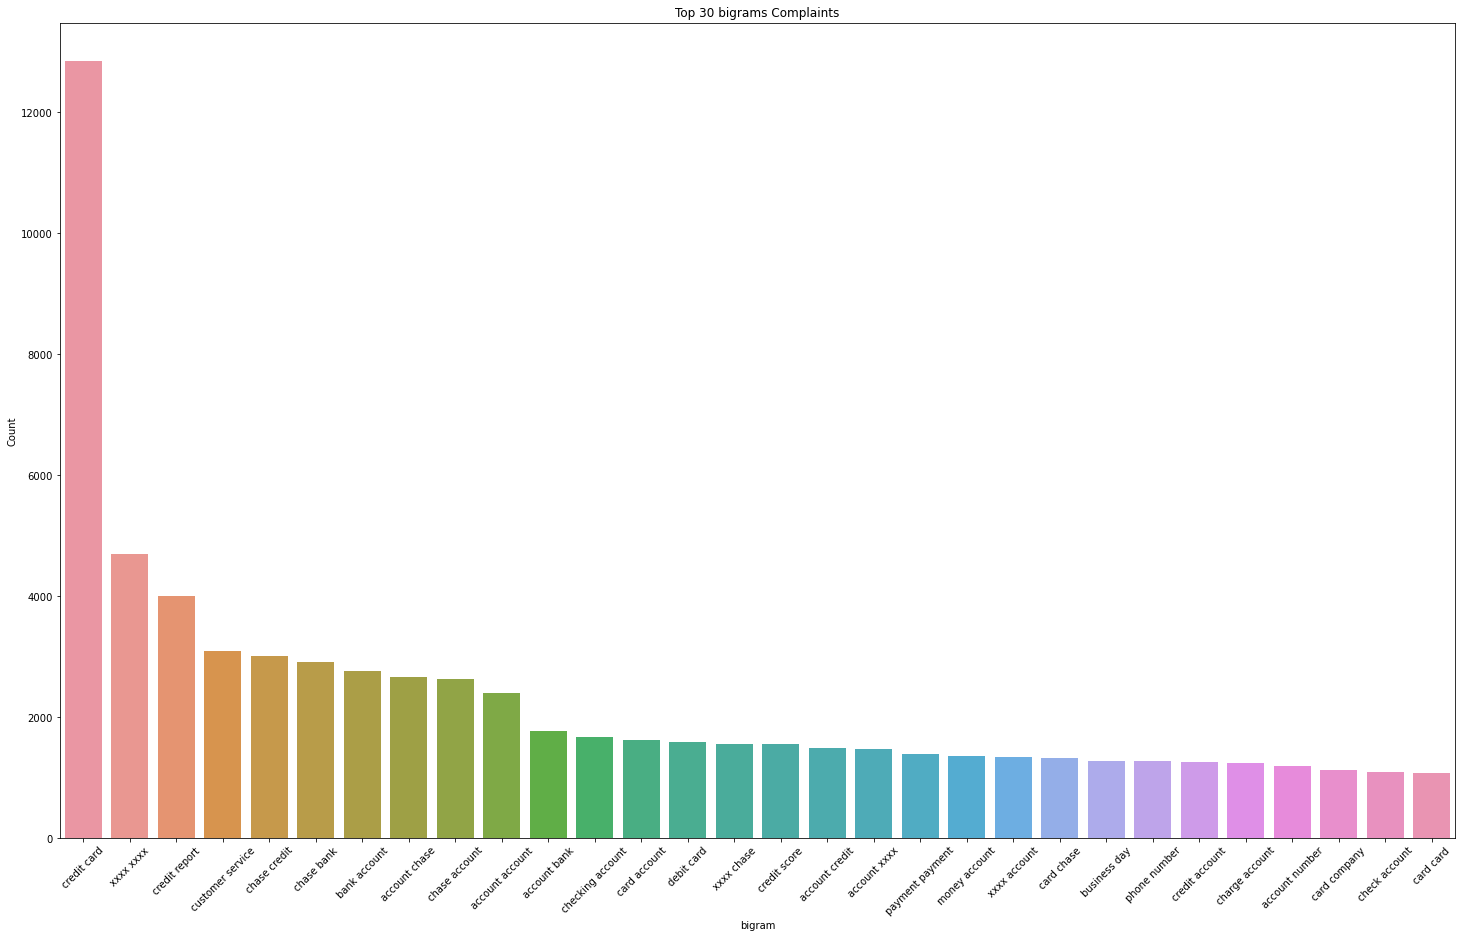

In [144]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_ngram(df_clean['Complaint_clean'],2,30)
df2 = pd.DataFrame(common_words, columns = ['bigram','Count'])
plt.figure(figsize = [25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df2['bigram'],y=df2['Count'])
plt.title("Top 30 bigrams Complaints")
plt.show()

In [145]:
#Print the top 10 words in the bigram frequency
df2.head(10)

,bigram,Count
0,credit card,12836
1,xxxx xxxx,4692
2,credit report,4003
3,customer service,3087
4,chase credit,3005
5,chase bank,2903
6,bank account,2759
7,account chase,2667
8,chase account,2631
9,account account,2395


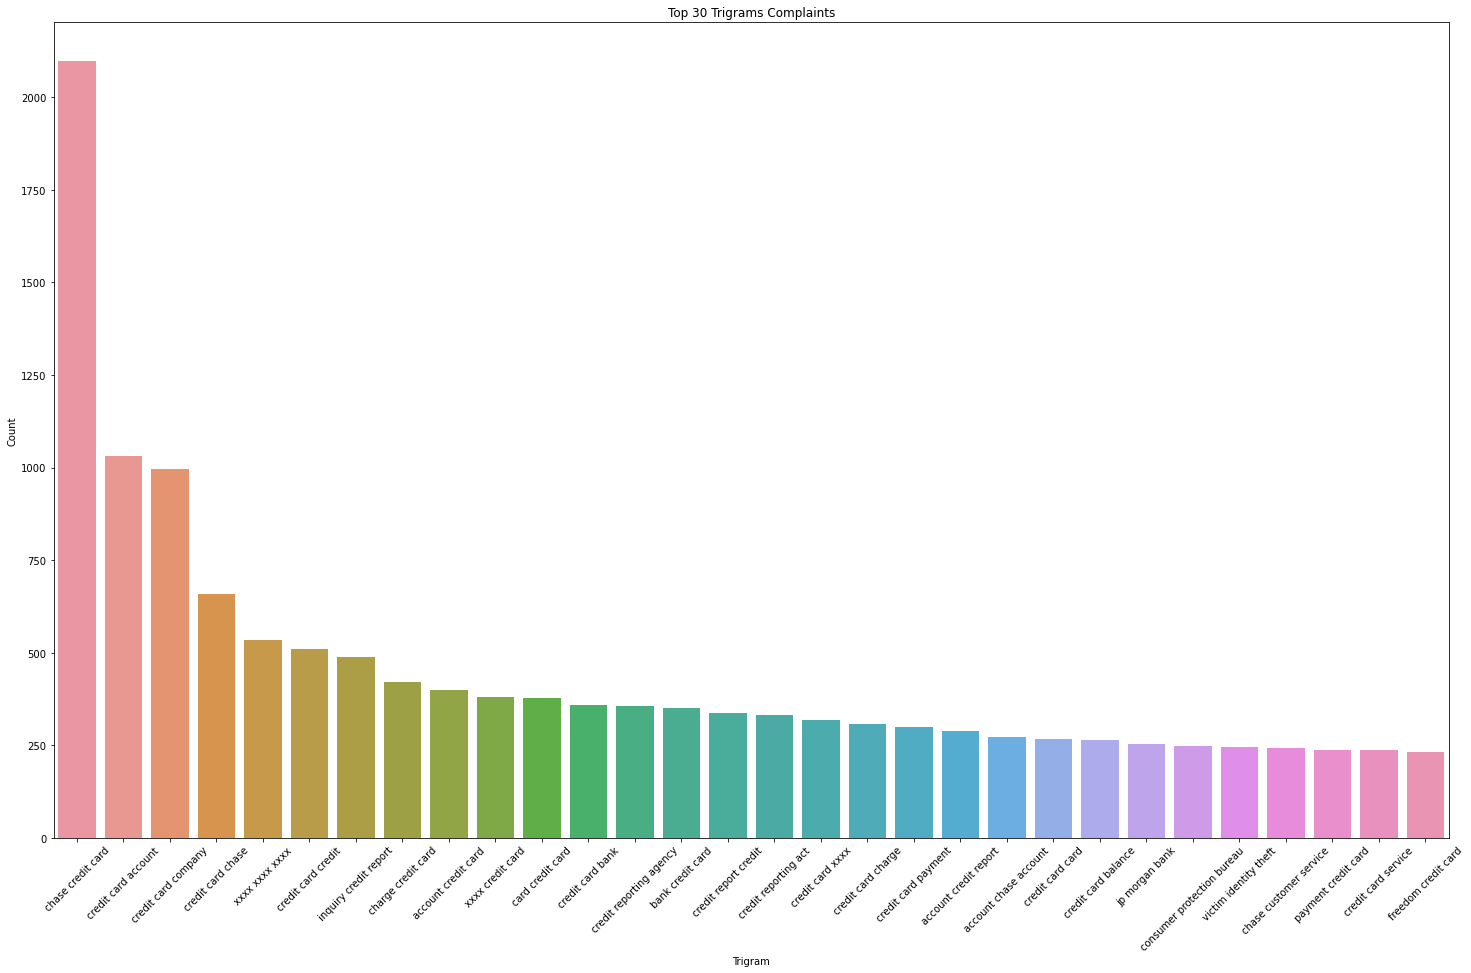

In [146]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_ngram(df_clean['Complaint_clean'],3,30)
df3 = pd.DataFrame(common_words, columns = ['Trigram','Count'])
plt.figure(figsize = [25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df3['Trigram'],y=df3['Count'])
plt.title("Top 30 Trigrams Complaints")
plt.show()

In [147]:
#Print the top 10 words in the trigram frequency
df3.head(10)

,Trigram,Count
0,chase credit card,2098
1,credit card account,1031
2,credit card company,996
3,credit card chase,657
4,xxxx xxxx xxxx,533
5,credit card credit,510
6,inquiry credit report,488
7,charge credit card,421
8,account credit card,400
9,xxxx credit card,379


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [148]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [149]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaints_lemma,complaint_POS_removed,complaint_len,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,482,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,card agent upgrade date agent information orde...,351,card agent upgrade date agent information orde...
2,chase card was reported on xx xx however fr...,chase card be report on xx xx however fra...,card application identity consent service cred...,220,card application identity consent service cred...
3,on xx xx while trying to book a xxxx xxxx ...,on xx xx while try to book a xxxx xxxx ...,try book xxxx ticket offer ticket card informa...,1470,try book ticket offer ticket card information...
4,my grand son give me check for i deposit ...,my grand son give I check for I deposit ...,son chase account fund bank account pay money ...,466,son chase account fund bank account pay money ...
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,668,card customer decade solicitation credit card ...
21068,on wednesday xx xx xxxx i called chas my xxx...,on wednesday xx xx xxxx I call chas my xxx...,visa credit card provider claim purchase prote...,2113,visa credit card provider claim purchase prote...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,2317,pay risk provide consumer bank app chase year ...
21070,i have had flawless credit for yrs i ve had ...,I have have flawless credit for yrs I ve h...,credit yrs credit card chase freedom xxxx prob...,2129,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [150]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(stop_words='english',min_df=2, max_df=0.95)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [151]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [152]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [153]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)#write your code here

In [154]:
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_
len(tfidf.get_feature_names())

6979

In [155]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics,15)),index=[f'Topic {i}' for i in range(num_topics)],
                          columns=[f'Word {i+1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]
topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 0,account,bank,check,money,fund,chase,deposit,branch,day,number,business,transaction,checking,claim,transfer
Topic 1,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,year,balance
Topic 2,payment,balance,month,fee,statement,auto,day,time,pay,date,credit,account,chase,year,mortgage
Topic 3,charge,card,fee,dispute,transaction,chase,merchant,purchase,fraud,claim,service,time,statement,refund,company
Topic 4,loan,mortgage,home,modification,chase,property,year,letter,rate,time,document,bank,house,foreclosure,sale


In [156]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
colnames = ["Topic {}".format(i) for i in range(nmf_model.n_components)]
complaintnames = ["Complaint{}".format(i) for i in range(len(df_clean.index))]
df_doc_topic = pd.DataFrame(W, columns=colnames, index=complaintnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_clean['topic_id'] = significant_topic

df_doc_topic


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,dominant_topic
Complaint0,0.022736,0.013029,0.006643,0.007176,0.021973,0
Complaint1,0.009102,0.014676,0.002140,0.011718,0.006001,1
Complaint2,0.000000,0.048598,0.000000,0.002289,0.000000,1
Complaint3,0.019078,0.063333,0.000661,0.006351,0.020359,1
Complaint4,0.067139,0.000000,0.000000,0.003546,0.009037,0
...,...,...,...,...,...,...
Complaint21067,0.000000,0.075471,0.017361,0.056254,0.000000,1
Complaint21068,0.007423,0.009993,0.000000,0.034989,0.011117,3
Complaint21069,0.015005,0.014861,0.000000,0.023066,0.009386,3
Complaint21070,0.000000,0.045308,0.095558,0.017329,0.000000,2


In [157]:
W = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(num_topics)], index=[f'Complaint{i}' for i in range(W.shape[0])])
W['max_topic'] = W.apply(lambda x: x.idxmax(), axis=1)
W[pd.notnull(W['max_topic'])].head(10)


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,max_topic
Complaint0,0.022736,0.013029,0.006643,0.007176,0.021973,Topic 0
Complaint1,0.009102,0.014676,0.002140,0.011718,0.006001,Topic 1
Complaint2,0.000000,0.048598,0.000000,0.002289,0.000000,Topic 1
Complaint3,0.019078,0.063333,0.000661,0.006351,0.020359,Topic 1
Complaint4,0.067139,0.000000,0.000000,0.003546,0.009037,Topic 0
Complaint5,0.000000,0.050767,0.000000,0.000000,0.000000,Topic 1
Complaint6,0.064839,0.002253,0.013981,0.008741,0.007122,Topic 0
Complaint7,0.003626,0.002000,0.054202,0.006582,0.046212,Topic 2
Complaint8,0.027252,0.000000,0.003327,0.055867,0.019669,Topic 3
Complaint9,0.000000,0.121516,0.000000,0.001934,0.001210,Topic 1


In [158]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W.max_topic.values   #write your code to assign topics to each rows.

In [159]:
df_clean_grp = df_clean.groupby('Topic')
df_clean_grp['Topic']

In [160]:
df_clean.shape

(21072, 7)

In [161]:
#Print the first 5 Complaint for each of the Topics
df_clean.head(5)


,complaint_what_happened,complaints_lemma,complaint_POS_removed,complaint_len,Complaint_clean,topic_id,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,482,morning name stop bank cardmember service ask ...,0,Topic 0
1,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,card agent upgrade date agent information orde...,351,card agent upgrade date agent information orde...,1,Topic 1
2,chase card was reported on xx xx however fr...,chase card be report on xx xx however fra...,card application identity consent service cred...,220,card application identity consent service cred...,1,Topic 1
3,on xx xx while trying to book a xxxx xxxx ...,on xx xx while try to book a xxxx xxxx ...,try book xxxx ticket offer ticket card informa...,1470,try book ticket offer ticket card information...,1,Topic 1
4,my grand son give me check for i deposit ...,my grand son give I check for I deposit ...,son chase account fund bank account pay money ...,466,son chase account fund bank account pay money ...,0,Topic 0


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [162]:
#Create the dictionary of Topic names and Topics
Topic_names = {
    'Topic 0':'Bank account services',
    'Topic 1':'Credit card / Prepaid card',
    'Topic 2':'Others',
    'Topic 3':'Theft/Dispute reporting',
    'Topic 4':'Mortgages/loans'    
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [163]:
df_clean.head()

,complaint_what_happened,complaints_lemma,complaint_POS_removed,complaint_len,Complaint_clean,topic_id,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,482,morning name stop bank cardmember service ask ...,0,Bank account services
1,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,card agent upgrade date agent information orde...,351,card agent upgrade date agent information orde...,1,Credit card / Prepaid card
2,chase card was reported on xx xx however fr...,chase card be report on xx xx however fra...,card application identity consent service cred...,220,card application identity consent service cred...,1,Credit card / Prepaid card
3,on xx xx while trying to book a xxxx xxxx ...,on xx xx while try to book a xxxx xxxx ...,try book xxxx ticket offer ticket card informa...,1470,try book ticket offer ticket card information...,1,Credit card / Prepaid card
4,my grand son give me check for i deposit ...,my grand son give I check for I deposit ...,son chase account fund bank account pay money ...,466,son chase account fund bank account pay money ...,0,Bank account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [164]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','topic_id']]

In [165]:
training_data.head()

,complaint_what_happened,topic_id
0,good morning my name is xxxx xxxx and i apprec...,0
1,i upgraded my xxxx xxxx card in xx xx and was...,1
2,chase card was reported on xx xx however fr...,1
3,on xx xx while trying to book a xxxx xxxx ...,1
4,my grand son give me check for i deposit ...,0


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [166]:
# Split the data to train and test sets

X_train_complaint, X_test_complaint, y_train, y_test = train_test_split(training_data['complaint_what_happened'],training_data['topic_id'], train_size=0.8,random_state=42)

In [167]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train_complaint)
X_test = count_vect.transform(X_test_complaint)

#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

In [168]:
y_train.shape

(16857,)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [169]:
# Write your code here to build any 3 models and evaluate them using the required metrics


# Code for Classification Metrics

def computeClassificationMetrics(y_test,y_test_pred,y_train,y_train_pred, plot=True,):
        print('*'*20+"Classification Report"+'*'*20)
        print('Performance on Train data: \nprecision: {0}\nRecall: {1}\nf1-score: {2}'.format(round(metrics.precision_score(y_train,
            y_train_pred, average='weighted'),4),round(metrics.recall_score(y_train,y_train_pred, average='weighted'),4),
              round(metrics.f1_score(y_train,y_train_pred, average='weighted'),4)))
        print('\nPerformance on Test data:\n',classification_report(y_test,y_test_pred))

In [170]:
# Function for training models

def model_fit(alg, X_train_data, y_train_data, X_test_data, y_test_data, plot=True):
    
    #Fit the algorithm on the data
    alg.fit(X_train_data, y_train_data)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train_data)
    #Predict validation set:
    y_test_pred = alg.predict(X_test_data)
      
    computeClassificationMetrics(y_test_data, y_test_pred,y_train_data,y_train_pred)

#### Model 1 : Logisitc Regression

In [171]:
logreg = LogisticRegression(random_state = 42, max_iter = 400)

model_fit(logreg, X_train, y_train, X_test, y_test, True)

********************Classification Report********************
Performance on Train data: 
precision: 0.9713
Recall: 0.9712
f1-score: 0.9712

Performance on Test data:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      1057
           1       0.93      0.94      0.93      1043
           2       0.96      0.87      0.91       447
           3       0.91      0.89      0.90       955
           4       0.93      0.94      0.93       713

    accuracy                           0.93      4215
   macro avg       0.93      0.92      0.92      4215
weighted avg       0.93      0.93      0.93      4215



#### Model 2: Decision Trees

In [172]:
dt = DecisionTreeClassifier(max_depth=8, random_state=40)

model_fit(dt,X_train,y_train,X_test,y_test,True)

********************Classification Report********************
Performance on Train data: 
precision: 0.8027
Recall: 0.784
f1-score: 0.7857

Performance on Test data:
               precision    recall  f1-score   support

           0       0.64      0.83      0.72      1057
           1       0.78      0.82      0.80      1043
           2       0.80      0.73      0.76       447
           3       0.75      0.63      0.68       955
           4       0.88      0.70      0.78       713

    accuracy                           0.75      4215
   macro avg       0.77      0.74      0.75      4215
weighted avg       0.76      0.75      0.75      4215



#### Model3: Random Forest

In [173]:
modRf = RandomForestClassifier(random_state=40)

model_fit(modRf,X_train,y_train,X_test,y_test,True)

********************Classification Report********************
Performance on Train data: 
precision: 1.0
Recall: 1.0
f1-score: 1.0

Performance on Test data:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85      1057
           1       0.82      0.88      0.85      1043
           2       0.94      0.46      0.62       447
           3       0.81      0.80      0.80       955
           4       0.87      0.86      0.87       713

    accuracy                           0.82      4215
   macro avg       0.85      0.78      0.80      4215
weighted avg       0.83      0.82      0.82      4215



#### Model 4: Naive Bayes

In [175]:
modNB = MultinomialNB()

model_fit(modNB,X_train,y_train,X_test,y_test,True)

********************Classification Report********************
Performance on Train data: 
precision: 0.7924
Recall: 0.7614
f1-score: 0.7247

Performance on Test data:
               precision    recall  f1-score   support

           0       0.65      0.91      0.76      1057
           1       0.72      0.77      0.75      1043
           2       1.00      0.02      0.04       447
           3       0.75      0.76      0.75       955
           4       0.85      0.77      0.81       713

    accuracy                           0.72      4215
   macro avg       0.79      0.65      0.62      4215
weighted avg       0.76      0.72      0.69      4215



### Conclusion : 

- For a given complaint set of data Logisitc Regression Model was able to perform well when compared to other models being trained.
 - F1 Score : 0.93
 - Precision : 0.93
 - Recall : 0.93